In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors


import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)




In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(c("/home/mark/R/x86_64-pc-linux-gnu-library/3.6","/usr/local/lib/R/site-library","/usr/lib/R/site-library","/usr/lib/R/library")) 
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)

library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)




In [4]:
ext = ".png"
colors_v = sc.pl.palettes.vega_20
sc.set_figure_params(dpi_save=450,fontsize=13)

plt.rcParams['figure.figsize']=(4,4)

plt.rcParams['axes.grid'] = False#


In [5]:
import scirpy as ir

In [6]:
import gzip

In [7]:
name = "GSM6346300_A10-B10-MCE12-MCE13"

In [8]:
path = "/home/bioinformatics/Documents/scSELpy_paper/final/cite_seq_TCR/"+name+"/"

In [9]:
GSM = name.split("_")[0]

In [10]:
TempDict = {}

In [11]:
TempDict[GSM] = sc.read(path+"matrix.mtx.gz").T
with gzip.open(path+"barcodes.tsv.gz","rb") as bc:
    barcodes = [x.decode()[:-1] for x in bc.readlines()]
TempDict[GSM].obs_names = [g.split("_")[0][-3:]+"_"+b for g,b in zip([GSM]*len(TempDict[GSM].obs),barcodes)] 
TempDict[GSM].obs["Sample"] = [GSM]*len(TempDict[GSM].obs_names)  
with gzip.open(path+"features.tsv.gz","rb") as feat:
    features = [x.decode()[:-1].split("\t") for x in feat.readlines()]
TempDict[GSM].var_names = [rx[0] for rx in features]
TempDict[GSM].var["Genes"] = [rx[1] for rx in features]
TempDict[GSM].var["Type"] = [rx[2] for rx in features]
adata_tcr = ir.io.read_10x_vdj(
    path+name+"-filtered_contig_annotations.csv.gz"
)
adata_tcr.obs_names = [g.split("_")[0][-3:]+"_"+b for g,b in zip([GSM]*len(adata_tcr.obs),adata_tcr.obs_names)] 
ir.pp.merge_with_ir(TempDict[GSM], adata_tcr)


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scirpy/io/_convert_anndata.py:81: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(obs=ir_df, X=np.empty([ir_df.shape[0], 0]))


In [12]:
adata = TempDict[GSM]

In [13]:
import numpy as np

In [14]:
adata.X = adata.X.toarray()

In [15]:

try:
    adata.X = adata.X.toarray()
except:
    pass
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

#Filtering for mitochondrial fraction, same as for ribosomal proteins. 
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var['Genes']]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']



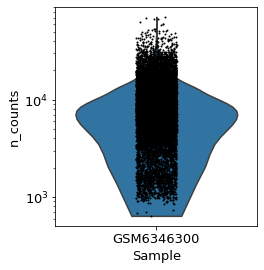

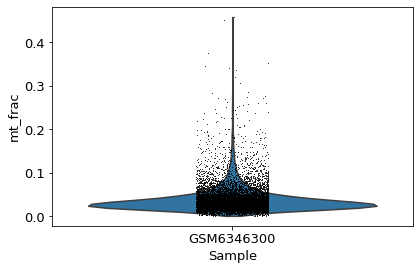

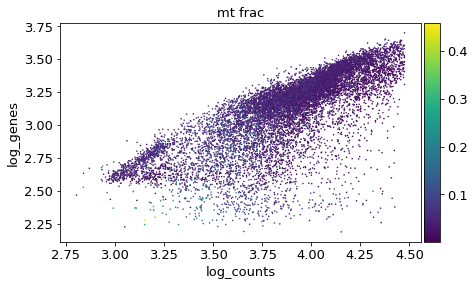

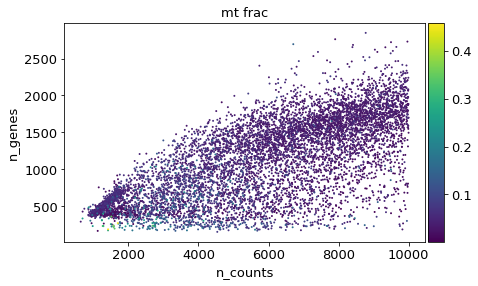

computing PCA
    with n_comps=50
    finished (0:00:16)


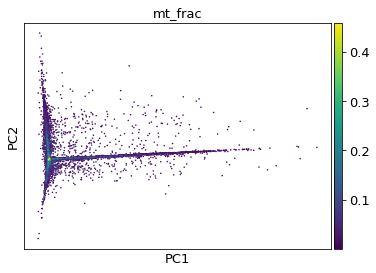

In [16]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='Sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='Sample')


p1 = sc.pl.scatter(adata[adata.obs['n_counts']<30000], 'log_counts', 'log_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')
sc.tl.pca(adata, svd_solver='arpack')
px1 = sc.pl.pca(adata, color='mt_frac')

In [17]:
    print('Total number of cells: {:d}'.format(adata.n_obs))

    sc.pp.filter_cells(adata, min_counts = 500)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

    sc.pp.filter_cells(adata, max_counts = 30000)
    print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

    adata = adata[adata.obs['mt_frac'] < 0.2]
    print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

    sc.pp.filter_cells(adata, min_genes = 250)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 12649
Number of cells after min count filter: 12649
filtered out 193 cells that have more than 30000 counts
Number of cells after max count filter: 12456
Number of cells after MT filter: 12403
filtered out 168 cells that have less than 250 genes expressed


/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of cells after gene filter: 12235


In [18]:
adata = adata[adata.obs["has_ir"] == "True"]

In [19]:
rawdata = adata.copy()

In [20]:
sc.pp.filter_genes(adata, min_cells=1) #We have to removed all genes expressed in less than 1 cell, otherwise the PCA won't work.

#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

filtered out 16621 genes that are detected in less than 1 cells


/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [21]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [22]:
#Delete adata_pp
try:
    del adata_pp
except:
    pass

# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()
#Normalize adata 

adata.raw = adata
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)




# Calculate the visualizations
sc.pp.pca(adata, n_comps=8, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=8) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=8
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 8
    using sklearn.manifold.TSNE


/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9952104  0.9919109  0.98811775 0.97993356 0.9770466
     0.96876603 0.9682277  0.9641353  0.96114975 0.9608085  0.955582
     0.94546664 0.93766606 0.9316159 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:18)


In [23]:
sc.tl.leiden(adata, key_added='leiden_r0.5', resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [24]:
adata = sc.read("../cite_seq_TCR/GSM6346300.h5ad")

In [25]:

#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
colors_v = sc.pl.palettes.vega_20

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


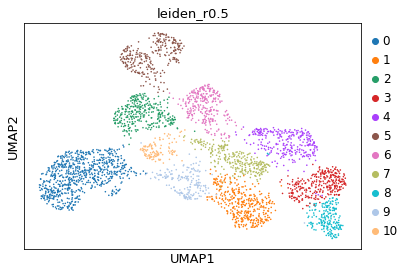

In [26]:
sc.pl.umap(adata,color="leiden_r0.5",save="_Figure_5_2"+ext,size=10)

In [27]:
import scselpy as scS
import scirpy as ir

In [28]:

MockDict={'scatter':[

[(7.5, 5824), (7.5, 242), (4237, 242), (4237, 5824)],
[(242, 5824), (242, 7.5), (4237, 7.5), (4237, 5824)]]}

In [29]:
predefined_colors = [colors_v[6],colors_v[8],colors_v[0],"lightgray"]

REMAP_1 was added to anndata.obs.
REMAP_1 was added to anndata.uns.


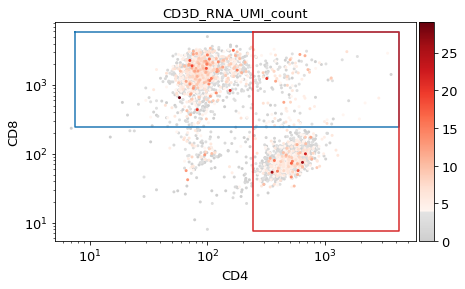

In [30]:
gene ="CD3D"
scS.pl.scatter(adata,"CD4","CD8",line_palette=[predefined_colors[2],predefined_colors[0]],save="_Figure_5_1"+ext,color=adata.var_names[list(adata.var["Genes"]).index(gene)],title=gene+"_RNA_UMI_count",color_map=mymap,printcords=True,use_log_scale=True,use_raw=True,mock=MockDict)

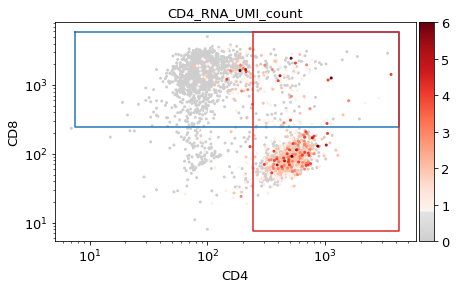

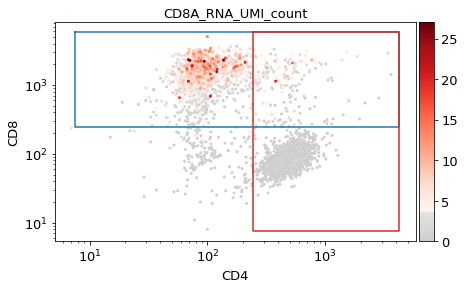

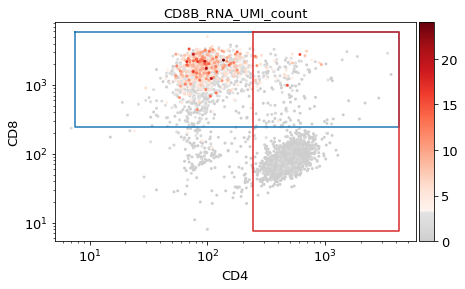

In [31]:
for num,gene in enumerate(["CD4","CD8A","CD8B"]):
    scS.pl.scatter(adata,"CD4","CD8",save="_Figure_S2_"+str(1+num)+ext,line_palette=[predefined_colors[2],predefined_colors[0]],color=adata.var_names[list(adata.var["Genes"]).index(gene)],title=gene+"_RNA_UMI_count",color_map=mymap,printcords=True,use_log_scale=True,use_raw=True,replot_lines="REMAP_1")

In [32]:
input_dict = {'1': 'CD8',
 '2': 'CD4',
 'Other': 'Other',
 '3':"CD45RA"
}

In [33]:
adata.obs['REMAP_1_renamed'] = scS.annotate.rename(adata.obs['REMAP_1'],input_dict)

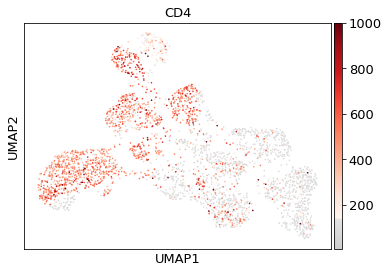

In [34]:
sc.pl.umap(adata,color="CD4",palette=sc.pl.palettes.default_20,vmax=1000,color_map=mymap,save="_Figure_S2_4"+ext,size=10)

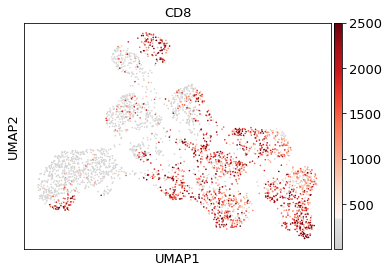

In [35]:
sc.pl.umap(adata,color="CD8",palette=sc.pl.palettes.default_20,vmax=2500,color_map=mymap,save="_Figure_S2_5"+ext,size=10)

In [36]:
ir.tl.chain_qc(adata)
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")


Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.


  0%|          | 0/2079 [00:00<?, ?it/s]

--> Done computing clonotype x clonotype distances.  (0:00:02)
Stored clonal assignments in `adata.obs["clone_id"]`.


In [37]:
Mock2 = {"umap":[[(0.5, 15), (0.5, 1.55), (17.35, 1.55), (17.35, 15)]]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


REMAP_2 was added to anndata.obs.
REMAP_2 was added to anndata.uns.


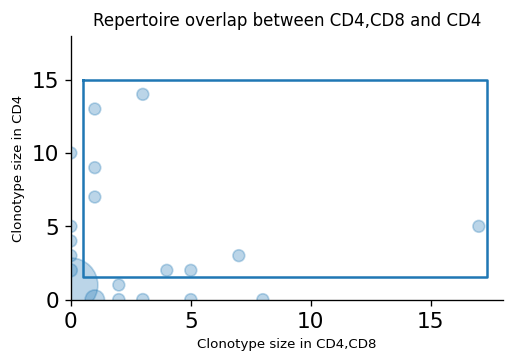

In [38]:
obs_inp="REMAP_1_renamed"
df, dst, lk = ir.tl.repertoire_overlap(adata, obs_inp, inplace=False)
df.head()
First = "CD4,CD8"
Second = "CD4"
dfT = df.T
adata.obsm['X_Repertoire'] = np.array([[dfT[First][ID],dfT[Second][ID]] if np.isnan(float(ID)) == False else [0.0,0.0] for ID in list(adata.obs["clone_id"])])
ir.pl.repertoire_overlap(
    adata, obs_inp, pair_to_plot=[First,Second], fig_kws={"dpi": 120}
)
scS.pl._scselpy.Remap(adata,override=True,groupby=obs_inp,printcords=True,scat_plot=False,pair_to_plot=[First,Second],save="Figure_5_4"+ext, remove_show_override=True,fig_kws={"dpi": 120},basis="X_Repertoire",plotattr=ir.pl.repertoire_overlap,mock=Mock2)


In [39]:
adata.obs["clone_id_filtered"] = [x if adata.obs["REMAP_2"][num] == "1" else "Other" for num,x in enumerate(adata.obs["clone_id"])]

In [40]:
adata.obs["CD4CD8_filtered"] = [x if adata.obs["REMAP_2"][num] == "1" else "Other_" for num,x in enumerate(adata.obs["REMAP_1_renamed"])]

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


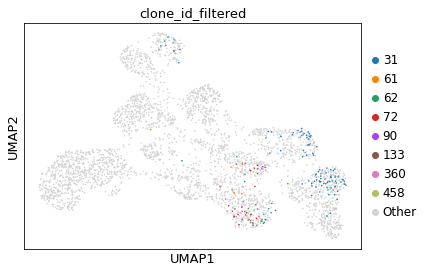

In [41]:
sc.pl.umap(adata,color="clone_id_filtered",size=10,palette=sc.pl.palettes.default_20[:8]+["lightgray"],save="_Figure_5_8"+ext)

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


REMAP_3 was added to anndata.obs.
REMAP_3 was added to anndata.uns.


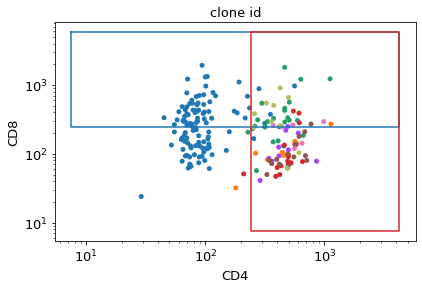

In [42]:
scS.pl.scatter(adata[adata.obs["clone_id_filtered"] != "Other"],"CD4","CD8",color="clone_id",line_palette=[predefined_colors[2],predefined_colors[0]],save="Figure_5_"+ext,size=100,printcords=True,use_log_scale=True,mock=MockDict)

In [43]:
Mock4 ={'umap':[[(1.9231572059889146, 11.695636721883535), (3.7939622635674777, 9.690961369014051), (5.365438511933469, 12.4707778583264), (2.5517477053353126, 14.154705154736767), (1.264633825721262, 13.433022027703753)]]}

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


REMAP_3 was added to anndata.obs.
REMAP_3 was added to anndata.uns.


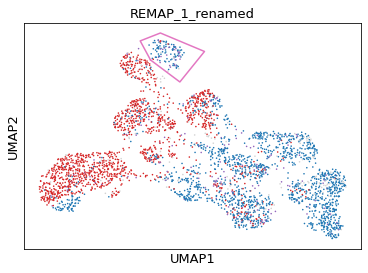

In [44]:

scS.pl.umap(adata,color="REMAP_1_renamed",color_map=mymap,gene_symbols="Genes",size=10,mock=Mock4,line_palette=[colors_v[12]],palette=predefined_colors,save="_Figure_5_3"+ext)



In [45]:
rem_obs = "REMAP_3"

In [46]:
abc = list(set(adata[adata.obs[rem_obs] == "1"].obs["clone_id"]))

In [47]:
adata.obs["cl_id_sel"] = ["!selected" if rem != "Other" else "cells_with_same_id_as_selection" if cl_id in abc else "@not_selected" for cl_id,rem in zip(adata.obs["clone_id"],adata.obs[rem_obs])]

In [48]:
adata.obs["leiden_adj"] = [cl+","+rem if rem != "Other" else cl for cl,rem in zip(adata.obs["leiden_r0.5"],adata.obs[rem_obs])]

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


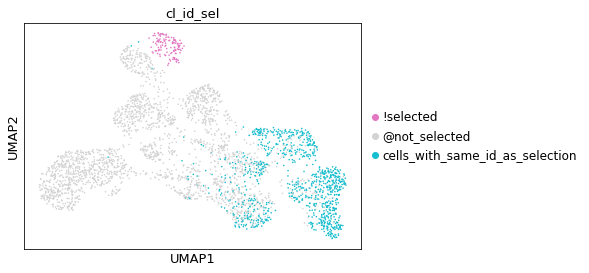

In [49]:
sc.pl.umap(adata,color="cl_id_sel",palette=[colors_v[12],"lightgray",colors_v[18]],save="_Figure_5_7"+ext,size=10)

/home/bioinformatics/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


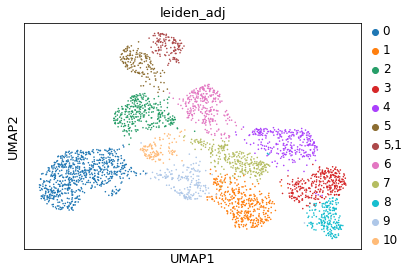

In [50]:
sc.pl.umap(adata,color="leiden_adj",save="_Figure_5_5"+ext,palette=sc.pl.palettes.default_20[:5]+[sc.pl.palettes.default_20[19],sc.pl.palettes.default_20[18]]+sc.pl.palettes.default_20[6:],size=10)

In [51]:
#adata.write("GSM6346300.h5ad")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


gm_kmeans = GaussianMixture(n_components=3, 
                            max_iter=1000, 
                            tol=1e-4,
                            init_params='kmeans')
y_gm_kmeans = gm_kmeans.fit_predict(adata.X[:,[list(adata.var["Genes"]).index("CD4"),list(adata.var["Genes"]).index("CD8A")] ])
#adata.obs["y_gm_kmeans"] = [str(x) for x in y_gm_kmeans]
sc.pl.umap(adata,color="y_gm_kmeans",save="_FigureS3_1"+ext,size=10)

In [ ]:

def Plotting_Barplot(AllDict,obs_inp,gene,gene_list_x_axis_set,ylabelStr,save=None,bbox_to_anchor=None,bbox_to_anchor2=None,color_start=0,TitleStr = None,Legends=True,colors_v=sc.pl.palettes.vega_20,set_ylim=None):
    import matplotlib
    backup_fig_size = plt.rcParams['figure.figsize'].copy()
    plt.rcParams['figure.figsize'] = (4,4)

    fig, ax = plt.subplots()

    ax.grid(visible=False)
    SpaceBetween = 0.1

    SpaceBetween = 1-SpaceBetween 

    barwidth = (SpaceBetween/len(AllDict))

    legend_list = []
    legend_label = []
    for num,Entry in enumerate(AllDict):
        color_int = num + color_start

        add = ((1-SpaceBetween)/2)+(num/len(AllDict))*SpaceBetween

        ax.bar([round(x+add,2) for x in range(len(AllDict[Entry]))],AllDict[Entry],width = barwidth,label = Entry,color=colors_v,edgecolor=colors_v)
  

    xvalues_of_bars = [xf.get_x() for xf in ax.get_children() if type(xf) == matplotlib.patches.Rectangle]
    value = (xvalues_of_bars[0]+0.5*SpaceBetween)
    if Legends:
        plt.legend(loc=1,bbox_to_anchor=bbox_to_anchor)
    if TitleStr == None:
        try:
            TitleStr = obs_inp+"_vs_"+gene
        except:
            TitleStr = ""
    SecondTS = ""
    

    plt.title(TitleStr+SecondTS,pad=12)
    plt.ylabel(ylabelStr)
    
    

    plt.xticks([x+value for x in range(len(gene_list_x_axis_set))],gene_list_x_axis_set,rotation=20)

    if set_ylim != None:
        ax.set_ylim(set_ylim)
    if save != None:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    
    plt.rcParams['figure.figsize'] = backup_fig_size
    
def GetBarPlot_reverse(adata,obs_inp,gene_list,save=None,var_inp="var_names",bbox_to_anchor=None,bbox_to_anchor2=None,color_start=0,TitleStr = None,Legends=None,colors_v=sc.pl.palettes.vega_20,set_ylim=None,use_raw=True,layer_key=None):
    import scselpy
    gene_list_x_axis_set = gene_list
    AllDict = {obs_inp:[scS.tl.calculate_TPM(adata,obs_inp,gene,which_var=var_inp,use_raw=False)[obs_inp] for gene in gene_list]}
    print(AllDict)
    ylabelStr = "TPM of gene on x-axis"

    
    Plotting_Barplot(AllDict,obs_inp,gene_list,gene_list_x_axis_set,ylabelStr,bbox_to_anchor=bbox_to_anchor,bbox_to_anchor2=bbox_to_anchor2,set_ylim=set_ylim,color_start=color_start,TitleStr = TitleStr,Legends=Legends,colors_v=colors_v,save=save)

In [ ]:
rawdata.obs["all"] = ["all"] * len(rawdata.obs)

In [ ]:
GetBarPlot_reverse(rawdata,"all",["CD4","CD8A","CD8B"],var_inp="Genes",use_raw=False,save="figures/FigureS3_3"+ext,colors_v=[predefined_colors[0],predefined_colors[2],"green"])